In [2]:
import fenics as fe
import matplotlib.pyplot as plt
import numpy as np

In [11]:
def D_different_sigma(sigma,x_interest,y_interest):
    # Mesh and Finite Element Discretization
    N_POINTS_P_AXIS = 32
    mesh = fe.UnitSquareMesh(N_POINTS_P_AXIS, N_POINTS_P_AXIS)
    lagrange_polynomial_space_first_order = fe.FunctionSpace(mesh, "Lagrange", 1)
    
    # Boundary Conditions
    def boundary_boolean_function(x, on_boundary): 
        return on_boundary
    
    homogeneous_dirichlet_boundary_condition = fe.DirichletBC(
        lagrange_polynomial_space_first_order,
        fe.Constant(0.0),
        boundary_boolean_function,
    )
    
    # The initial condition
    parameter = 10
    x0, y0 = 0, 0  # Center of the initial condition in the unit square
    magnitude = 1
    initial_condition = fe.Expression("magnitude*(1-exp(-1/(parameter*parameter*(pow(x[0] - x0, 2) + pow(x[1] - y0, 2)))))", 
                                      degree=2, magnitude=magnitude, parameter=parameter, x0=x0, y0=y0, domain=mesh)
    
    # Discretize the initial condition
    u_old = fe.interpolate(initial_condition, lagrange_polynomial_space_first_order)
    
    # Parameters for the Gaussian function
    A = 1.0          # Peak amplitude
    x0, y0 = 0, 0  # Center of the Gaussian in the unit square
    sigma = sigma       # Standard deviation (controls the spread)
    
    # Define the Gaussian diffusion coefficient
    D = fe.Expression("A * exp(-((x[0] - x0)*(x[0] - x0) + (x[1] - y0)*(x[1] - y0)) / (2 * sigma))",
                      degree=2, A=A, x0=x0, y0=y0, sigma=sigma, domain=mesh)
    
    # Time-stepping parameters
    time_step_length = 0.001
    n_time_steps = 100
    
    #Create the finite element problem
    u_trial = fe.TrialFunction(lagrange_polynomial_space_first_order)
    v_test = fe.TestFunction(lagrange_polynomial_space_first_order)
    
    weak_form_residuum = (
        (u_trial * v_test * fe.dx
        +
        time_step_length * (fe.dot(fe.grad(u_trial), fe.grad(D)) * v_test 
                            +
                            D * fe.dot(fe.grad(u_trial), fe.grad(v_test))) * fe.dx)
        -
        (
            u_old * v_test * fe.dx
            +
            time_step_length * fe.dot(fe.grad(D), fe.grad(u_trial)) * v_test * fe.dx
        )
    )
    
    #We have a linear PDE that is separable into a lhs and rhs
    weak_form_lhs = fe.lhs(weak_form_residuum)
    weak_form_rhs = fe.rhs(weak_form_residuum)
    
    # Solution function for each timestep
    u_solution = fe.Function(lagrange_polynomial_space_first_order)
    
    # Define the point of interest
    point_of_interest = (x_interest,y_interest)
    
    # Time-stepping loop
    time_current = 0.0
    value_set = []
    for i in range(n_time_steps):
    
        # Solve the PDE for the current time step
        fe.solve(weak_form_lhs == weak_form_rhs, u_solution, homogeneous_dirichlet_boundary_condition)

        # Update the previous solution
        u_old.assign(u_solution)
        
        # Extract the solution at the specific point and store it
        point_value = u_solution(point_of_interest)
        value_set.append(point_value)

        time_current += time_step_length

    time = time_step_length*value_set.index(max(value_set))
    return time

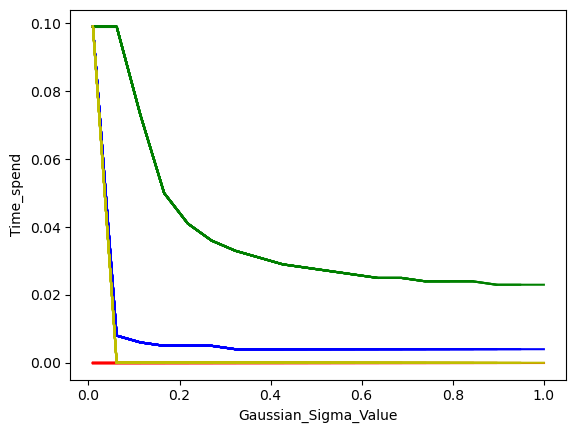

In [17]:
# Got time and sigma variation
Time = []
sigma = []
point_of_interest = [[0,0],[0.25,0.25],[0.5,0.5],[1,1]]
color = ['r','b','g','y']
m = 0
for k in point_of_interest:
    color_i = color[m]
    m += 1
    for i in np.linspace(0.01,1,20):
        sigma.append(i)
        Time.append(D_different_sigma(i,k[0],k[1]))
        plt.plot(sigma, Time, color_i)
        plt.xlabel("Gaussian_Sigma_Value")
        plt.ylabel("Time_spend")
    sigma = []
    Time = []
plt.show()